In [30]:
import matplotlib.pyplot as plt
import os
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools
import os
import time
import numpy as np
import sys
from DensityFieldTools import DensityField3D, PkX
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras import backend as K
tf.config.list_physical_devices('GPU')
from UNET import UNET3D
import numpy as np
from tqdm import tqdm
print(tf.config.list_physical_devices('GPU'))
from astropy.stats import sigma_clip as clip 

BoxSize = 1024.
kF = 2*np.pi/BoxSize
grid = 256

from mpl_toolkits.axes_grid1 import make_axes_locatable

/net/comas/data/users/bidenko/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/net/comas/data/users/bidenko/py310/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
physical_devices = tf.config.list_physical_devices()

In [4]:
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
config = tf.config.experimental.set_visible_devices(physical_devices[0])
# tf.debugging.set_log_device_placement(False)

In [10]:

lst = os.listdir('./oldfmat/fmat/')

flst = []
for i in lst:
    if ('tb_vbig' in i) & ('Tvm' in i): flst.append(i[8:-4])

        
        
flst = np.array(flst)

def cutfield(delta,BoxSize,grid,maxk_kF):
    # Cuts the density field at kmax = maxk_kF * kF 
    kF = 2*np.pi/BoxSize
    cell_size = BoxSize/grid
    # indexing="ij" means the array are indexed A[xi][yi][zi]
    kx = 2 * np.pi * np.fft.fftfreq(grid, cell_size)
    ky = 2 * np.pi * np.fft.fftfreq(grid, cell_size)
    kz = 2 * np.pi * np.fft.rfftfreq(grid, cell_size)
    k = tf.meshgrid(kx,ky,kz,indexing="ij")
    kgrid = tf.sqrt(k[0]**2 + k[1]**2 + k[2]**2)

    bools = (kgrid >= maxk_kF*kF)
    
    c_fftgrid = tf.signal.rfft3d(delta)
    c_fftgrid = tf.where(bools,0.+0.j,c_fftgrid)
    r_fftgrid = tf.signal.irfft3d(c_fftgrid)

    return r_fftgrid

import matplotlib.pyplot as plt


In [11]:
from matplotlib.patches import Ellipse as ell

In [12]:


temp = []
for i in lst:
    if ('tb_vbig' in i) & ('Tvm' in i): 
        p = i.find('m_')
        temp.append(i[p+2:p+6])

temp = np.array(temp)
temp[temp=='4.7_'] = '4.7'
axx = []
for i in lst:
    if ('tb_vbig' in i) & ('Tvm' in i): 
        p = i.find('x_')
        if p == -1: axx.append('1.0')
        else: axx.append(i[p+2:p+7])

axx  = np.array(axx)

xh = []
for i in lst:
    if ('tb_vbig' in i) & ('Tvm' in i): 
        p = i.find('h_')
        if p == -1: xh.append('1.0')
        else: xh.append(i[p+2:p+6])

xh  = np.array(xh)

ut = np.unique(temp)
ua = np.unique(axx)
ux = np.unique(xh)

seedd = []
for i in lst:
    if 'delta_HII_EFF_FACTOR_max' in i: seedd.append(i[25:-4])

selector = []
for i in range(len(ut)):
    for j in range(len(ua)):
        for k in range(len(ux)):   
            selector.append(np.where((temp ==ut[i]) & (axx ==ua[j]) & (xh ==ux[k]))[0])

In [13]:
seeds = [93645,75309,57472,76769]

In [14]:
astroparams = {}
astroparams['ION_Tvir_MIN']  = {'min':4.68,'mean':4.70,'max':4.72}
astroparams['HII_EFF_FACTOR']  = {'min':29.,'mean':30.,'max':31.}
astroparams['X_RAY_SPEC_INDEX'] = {'min':0.955,'mean':1.000,'max':1.045}
astroparams_mean = {}
for i in astroparams.keys():
    astroparams_mean[i]  = astroparams[i]['mean']
    

In [15]:
means = astroparams_mean['ION_Tvir_MIN'],astroparams_mean['HII_EFF_FACTOR'],astroparams_mean['X_RAY_SPEC_INDEX']

In [16]:
data = {}
data['ts'] = {}
data['tb'] = {}
data['dr'] = {}

data['xh'] = {}

b = 0
for k in seeds[0:4]:
    data['ts']['%s'%k] = {}
    data['tb']['%s'%k] = {}
    data['dr']['%s'%k] = {}
    data['xh']['%s'%k] = {}
    data['dr']['%s'%k]['fed'] = np.load('./oldfmat/fmat/delta_vbig_%s'%k+'_Tvm_4.7_ax_1.000_xh_30.0.npy')
    data['ts']['%s'%k]['fed'] = np.load('./oldfmat/fmat/ts_vbig_%s'%k+'_Tvm_4.7_ax_1.000_xh_30.0.npy')
    data['tb']['%s'%k]['fed'] = np.load('./oldfmat/fmat/tb_vbig_%s'%k+'_Tvm_4.7_ax_1.000_xh_30.0.npy')
    data['xh']['%s'%k]['fed'] = np.load('./oldfmat/fmat/xh_vbig_%s'%k+'_Tvm_4.7_ax_1.000_xh_30.0.npy')
    
    for i1 in ['min','max','mean']:
        for i2 in ['min','max','mean']:
            for i3 in ['min','max','mean']:
                 iarr = np.array([i1,i2,i3])
                 if sum((iarr) =='mean')==2:
                    b+=1
                    i = np.array(list(astroparams.keys()))[iarr!='mean'][0]
                    j = iarr[iarr!='mean'][0]
                    # print(i,j)
                    it,ia,ix = astroparams['ION_Tvir_MIN'][i1],astroparams['X_RAY_SPEC_INDEX'][i3],astroparams['HII_EFF_FACTOR'][i2]
                    # print(it,ia,ix)
                    data['dr']['%s'%k]['%s_%s'%(i,j)] = np.load('./oldfmat/fmat/delta_vbig_%s'%k+'_Tvm_'+'%s'%it+'_ax_'+'%.3f'%ia+'_xh_'+'%s'%ix+'.npy')
                    data['ts']['%s'%k]['%s_%s'%(i,j)] = np.load('./oldfmat/fmat/ts_vbig_%s'%k+'_Tvm_'+'%s'%it+'_ax_'+'%.3f'%ia+'_xh_'+'%s'%ix+'.npy')
                    data['tb']['%s'%k]['%s_%s'%(i,j)] = np.load('./oldfmat/fmat/tb_vbig_%s'%k+'_Tvm_'+'%s'%it+'_ax_'+'%.3f'%ia+'_xh_'+'%s'%ix+'.npy')
                    data['xh']['%s'%k]['%s_%s'%(i,j)] = np.load('./oldfmat/fmat/xh_vbig_%s'%k+'_Tvm_'+'%s'%it+'_ax_'+'%.3f'%ia+'_xh_'+'%s'%ix+'.npy')

In [17]:
seeds = data['ts'].keys()

In [18]:
BoxSize = 1024
grid = 256
Pk = {}
for k in data['ts'].keys():
    Pk[k] = {}
    for i in data.keys():
        Pk[k][i] = {}
        field = DensityField3D(BoxSize,grid,nthreads=50)
        field.read_real(data[i]['%s'%k]['fed'],MAS='PCS')
        Pk[k][i]['fed'] = field.Pk() 
        kk = Pk[k][i]['fed'][:,0]

        Pk[k][i]['fed'] = Pk[k][i]['fed'][:,0+1]
        for l in astroparams.keys():
            for j in ['min','max']:
                        field = DensityField3D(BoxSize,grid,nthreads=50)
                        field.read_real(data[i]['%s'%k]['%s_%s'%(l,j)],MAS='PCS')
                        Pk[k][i]['%s_%s'%(l,j)] = field.Pk() 
                        Pk[k][i]['%s_%s'%(l,j)] = Pk[k][i]['%s_%s'%(l,j)][:,0+1]

In [19]:
data['dr']['57472']['fed'].shape

(256, 256, 256)

In [20]:
kcut = 78
kcut1 = 5

In [21]:
Pcross = []

for i in data['ts'].keys():
    Pcross.append(PkX(data['ts'][i]['fed'],1024.,data['tb'][i]['fed'],MAS=["PCS","PCS"],nthreads=40))

In [22]:
Pcross2 = []

for i in data['ts'].keys():
    Pcross2.append(PkX(data['xh'][i]['fed'],1024.,data['tb'][i]['fed'],MAS=["PCS","PCS"],nthreads=40))

In [23]:
tb = np.load('./test_data/tb_testset_90.npy',allow_pickle=True)[:,:,:,:,np.newaxis]
ts = np.load('./test_data/ts_testset_90.npy',allow_pickle=True)[:,:,:,:,np.newaxis]
x = np.load('./test_data/x_testset_90.npy',allow_pickle=True)[:,:,:,:,np.newaxis]
d = np.load('./test_data/d_testset_90.npy',allow_pickle=True)[:,:,:,:,np.newaxis]

In [24]:
P_tstb = []
P_dtb = []
P_xtb = []

for i in range(len(tb)):
    P_tstb.append(PkX(ts[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_dtb.append(PkX(d[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))
    P_xtb.append(PkX(x[i,:,:,:,0],1024.,tb[i,:,:,:,0],MAS=["PCS","PCS"],nthreads=120))

In [25]:
P_xtb = np.array(P_xtb)
P_dtb = np.array(P_dtb)
P_tstb = np.array(P_tstb)

In [26]:
def plot(kmin=0,kmax=-1):
    lf = 1.
    a2,b2,tan2,p,c,a22,b22,tan22,a2s,b2s,tan2s,ps,cs,a2x,b2x,tan2x,px,cx,a2x2,b2x2,a2s2,b2s2,tan2s =calc(kmin,kmax)
    fig, axes = plt.subplots(figsize=(6, 6), sharey='row', sharex='col', ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    fig.set_figwidth(7.05556)
    fig.set_figheight(7.05556)
    fig.set_dpi(250)
    x = np.linspace(0, 10, 100)
    axes[0,0].set_yticks([])
    for i in range(3):
        axes[i,0].set_ylabel([r'$\log_{10}(T_{\rm{vir}}^{\rm{min}})$',r"$\zeta$",r'$\alpha_{\rm X}$'][i],{'fontsize':11})
        for j in range(3):
            axes[i,j].tick_params(axis='both', which='major', labelsize=8,rotation=45)
            if i<=j:
                axes[i, j].axis('off')
            else:

                axes[i,j].set_xlabel([r'$\log_{10}(T_{\rm{vir}}^{\rm{min}})$',r"$\zeta$",r'$\alpha_{\rm X}$'][j],{'fontsize':11})

                axes[i,j].set_xlim((means[j]-2*c[j][j]**0.5*lf,means[j]+2*c[j][j]**0.5*lf))
                axes[i,j].set_ylim((means[i]-2*c[i][i]**0.5*lf,means[i]+2*c[i][i]**0.5*lf))
                if i==2 and j == 1:
                    e1 = ell((means[j],means[i]),a2s[j][i]**0.5,b2s[j][i]**0.5,angle=tan2s[j][i],linewidth=2,alpha=0.3,color='r')
                    e2 = ell((means[j],means[i]),a2[j][i]**0.5,b2[j][i]**0.5,angle=tan2[j][i],linewidth=2,alpha=0.3,color='b')
                else:
                    e1 = ell((means[j],means[i]),a2s[j][i]**0.5,b2s[j][i]**0.5,angle=90+tan2s[j][i],linewidth=2,alpha=0.3,color='r')
                    e2 = ell((means[j],means[i]),a2[j][i]**0.5,b2[j][i]**0.5,angle=90+tan2[j][i],linewidth=2,alpha=0.3,color='b')



                axes[i,j].add_patch(e1)
                axes[i,j].add_patch(e2)

                if i==2 and j == 1:
                    e1 = ell((means[j],means[i]),a2s2[j][i]**0.5,b2s2[j][i]**0.5,angle=tan2s[j][i],linewidth=2,alpha=0.3,color='r')
                    e2 = ell((means[j],means[i]),a22[j][i]**0.5,b22[j][i]**0.5,angle=tan2[j][i],linewidth=2,alpha=0.3,color='b')
                else:
                    e1 = ell((means[j],means[i]),a2s2[j][i]**0.5,b2s2[j][i]**0.5,angle=90+tan2s[j][i],linewidth=2,alpha=0.3,color='r')
                    e2 = ell((means[j],means[i]),a22[j][i]**0.5,b22[j][i]**0.5,angle=90+tan2[j][i],linewidth=2,alpha=0.3,color='b')

                e3 = ell((means[j],means[i]),a2x[j][i]**0.5,b2x[j][i]**0.5,angle=90+tan2x[j][i],linewidth=2,alpha=0.3,color='g')
                axes[i,j].add_patch(e3)
                e3 = ell((means[j],means[i]),a2x2[j][i]**0.5,b2x2[j][i]**0.5,angle=90+tan2x[j][i],linewidth=2,alpha=0.3,color='g')
                axes[i,j].add_patch(e3)


                axes[i,j].add_patch(e1)
                axes[i,j].add_patch(e2)



    axes[0,0].set_ylim(axes[0,0].get_xlim())
    axes[-1,-1].set_xlim(axes[-1,-1].get_ylim())
    a=1
    sigmas = {}
    sigmas['tb'] = np.zeros(3)
    sigmas['ts'] = np.zeros(3)
    sigmas['xh'] = np.zeros(3)
    for i in range(3):
        for j in range(3):
            if i==j:
                ax1 = fig.add_subplot(3,3,a)
                xlims = axes[i,i].get_xlim()
                ax1.set_xlim(xlims)
                ax1.set_yticks([])
                if i!=7: ax1.set_xticks([])
                ax1.tick_params(axis='both', which='major', labelsize=8,rotation=45)
                xx = np.linspace(xlims[0],xlims[1])


                sigma2 = c[i][i]
                ax1.plot(xx,np.exp(-(xx-means[i])**2 / sigma2)/sigma2**.5,'tab:blue')
                sigmas['tb'][i] = np.sqrt(sigma2)

                sigma2 = cs[i][i]
                ax1.plot(xx,np.exp(-(xx-means[i])**2 / sigma2)/sigma2**.5,'tab:red')
                sigmas['ts'][i] = np.sqrt(sigma2)

                sigma2 = cx[i][i]
                ax1.plot(xx,np.exp(-(xx-means[i])**2 / sigma2)/sigma2**.5,'tab:green')
                sigmas['xh'][i] = np.sqrt(sigma2)

            a+=1 

    plt.legend(['$T_b$','$T_s$',r'$x_{\rm HI}$'],bbox_to_anchor=[0.5,2.9],prop={'size': 11})
    fig.savefig('../fig/fisher.pdf',bbox_inches='tight')
    return sigmas

In [27]:
def get_sigmas(kmin=0,kmax=-1):
    lf = 1.
    a2,b2,tan2,p,c,a22,b22,tan22,a2s,b2s,tan2s,ps,cs,a2x,b2x,tan2x,px,cx,a2x2,b2x2,a2s2,b2s2,tan2s =calc(kmin,kmax)

    sigmas = {}
    sigmas['tb'] = np.zeros(3)
    sigmas['ts'] = np.zeros(3)
    sigmas['xh'] = np.zeros(3)
    for i in range(3):
        for j in range(3):
            if i==j:
              
              
              
                sigma2 = c[i][i]
                sigmas['tb'][i] = np.sqrt(sigma2)

                sigma2 = cs[i][i]
                sigmas['ts'][i] = np.sqrt(sigma2)

                sigma2 = cx[i][i]
                sigmas['xh'][i] = np.sqrt(sigma2)
    return sigmas

In [28]:
def calc(kmin=0,kmax=-1):
    kcut = kmax
    kcut1 = kmin
    BoxSize = 1024
    grid = 256
    dp = {}
    for k in data['ts'].keys():
        dp[k] = {}
        for i in data.keys():
            dp[k][i] = {}
            for l in astroparams.keys():
                dp[k][i][l] = Pk[k][i]['%s_max'%l][kcut1:kcut]-Pk[k][i]['%s_min'%l][kcut1:kcut]

    obs = dp['93645'].keys()

    sumder = {}
    ch = 0
    for j in astroparams.keys():
        sumder[j] = {}
        for k in obs:
            sumder[j][k] = np.zeros(kk.shape)[kcut1:kcut]
            for i in seeds:
                sumder[j][k] += dp[i][k][j]/len(seeds)/(astroparams[j]['max']-astroparams[j]['min'])
                ch =1

    ### cut here

    sumfed = {}
    for k in obs:
        sumfed[k] = np.zeros(kk.shape)[kcut1:kcut]
        for i in seeds:
            sumfed[k] += Pk[i][k]['fed'][kcut1:kcut]/len(seeds)


    ###
    ###
    ###

    Cm1 = {}
    Cm1['ts'] =np.diag(1/np.var(P_tstb,axis=0).T[1][kcut1:kcut])
    Cm1['dr'] =np.diag(1/np.var(P_dtb,axis=0).T[1][kcut1:kcut])
    Cm1['tb'] =np.diag(1/np.var(P_xtb,axis=0).T[2][kcut1:kcut])
    Cm1['xh'] =np.diag(1/np.var(P_xtb,axis=0).T[1][kcut1:kcut])

    params = list(sumder.keys())

    ###
    ###
    ###

    Fmat = {}
    for i in obs:
        Fmat[i] = np.zeros((3,3))
        for j in range(3):
            for k in range(3):
                Fmat[i][j][k] = np.dot(np.dot(sumder[params[j]][i],Cm1[i]),sumder[params[k]][i].T)

    C = {}
    C['ts'] = np.linalg.inv(Fmat['ts'])
    C['xh'] = np.linalg.inv(Fmat['xh'])
    C['tb'] = np.linalg.inv(Fmat['tb'])

    means = astroparams_mean['ION_Tvir_MIN'],astroparams_mean['HII_EFF_FACTOR'],astroparams_mean['X_RAY_SPEC_INDEX']

    a2 = np.zeros((3,3))
    b2 = np.zeros((3,3))
    tan2 = np.zeros((3,3))
    p = np.zeros((3,3))
    c = C['tb']
    for i in range(3):
        for j in range(3):
                a2[i,j] = ((c[i][i]+c[j][j])/2.+np.sqrt((c[i][i]-c[j][j])**2./4.+c[i][j]**2))*2.3
                b2[i,j] = ((c[i][i]+c[j][j])/2.-np.sqrt((c[i][i]-c[j][j])**2./4.+c[i][j]**2))*2.3
                ###
                if i!=j: tan2[i,j] = np.rad2deg(np.arctan(2.*c[i][j]/(c[i][i]-c[j][j]))/2)
                p[i,j] = c[i][j]/c[i][i]**0.5/c[j][j]**0.5

    a22 = np.zeros((3,3))
    b22 = np.zeros((3,3))
    tan22 = np.zeros((3,3))
    p = np.zeros((3,3))
    c = C['tb']
    for i in range(3):
        for j in range(3):
                a22[i,j] = ((c[i][i]+c[j][j])/2.+np.sqrt((c[i][i]-c[j][j])**2./4.+c[i][j]**2))*6.17
                b22[i,j] = ((c[i][i]+c[j][j])/2.-np.sqrt((c[i][i]-c[j][j])**2./4.+c[i][j]**2))*6.17
                ####
                if i!=j: tan2[i,j] = np.rad2deg(np.arctan(2.*c[i][j]/(c[i][i]-c[j][j]))/2)
                p[i,j] = c[i][j]/c[i][i]**0.5/c[j][j]**0.5

    a2s = np.zeros((3,3))
    b2s = np.zeros((3,3))
    tan2s = np.zeros((3,3))
    ps = np.zeros((3,3))
    cs = C['ts']
    for i in range(3):
        for j in range(3):
                a2s[i,j] = ((cs[i][i]+cs[j][j])/2.+np.sqrt((cs[i][i]-cs[j][j])**2./4.+cs[i][j]**2))*2.3
                b2s[i,j] = ((cs[i][i]+cs[j][j])/2.-np.sqrt((cs[i][i]-cs[j][j])**2./4.+cs[i][j]**2))*2.3
                if i!=j: tan2s[i,j] = np.rad2deg(np.arctan(2.*cs[i][j]/(cs[i][i]-cs[j][j]))/2)
                ps[i,j] = cs[i][j]/cs[i][i]**0.5/cs[j][j]**0.5

    a2x = np.zeros((3,3))
    b2x = np.zeros((3,3))
    tan2x = np.zeros((3,3))
    px = np.zeros((3,3))
    cx = C['xh']
    for i in range(3):
        for j in range(3):
                a2x[i,j] = ((cx[i][i]+cx[j][j])/2.+np.sqrt((cx[i][i]-cx[j][j])**2./4.+cx[i][j]**2))*2.3
                b2x[i,j] = ((cx[i][i]+cx[j][j])/2.-np.sqrt((cx[i][i]-cx[j][j])**2./4.+cx[i][j]**2))*2.3
                if i!=j: tan2x[i,j] = np.rad2deg(np.arctan(2.*cx[i][j]/(cx[i][i]-cx[j][j]))/2)
                px[i,j] = cx[i][j]/cx[i][i]**0.5/cx[j][j]**0.5

    a2x2 = np.zeros((3,3))
    b2x2 = np.zeros((3,3))
    # tan2x2 = np.zeros((3,3))
    # px2 = np.zeros((3,3))
    # cx2 = C['xh']
    for i in range(3):
        for j in range(3):
                a2x2[i,j] = ((cx[i][i]+cx[j][j])/2.+np.sqrt((cx[i][i]-cx[j][j])**2./4.+cx[i][j]**2))*6.17
                b2x2[i,j] = ((cx[i][i]+cx[j][j])/2.-np.sqrt((cx[i][i]-cx[j][j])**2./4.+cx[i][j]**2))*6.17
                if i!=j: tan2x[i,j] = np.rad2deg(np.arctan(2.*cx[i][j]/(cx[i][i]-cx[j][j]))/2)
                px[i,j] = cx[i][j]/cx[i][i]**0.5/cx[j][j]**0.5

    a2s2 = np.zeros((3,3))
    b2s2 = np.zeros((3,3))
    tan2s = np.zeros((3,3))
    ps = np.zeros((3,3))
    cs = C['ts']
    for i in range(3):
        for j in range(3):
                a2s2[i,j] = ((cs[i][i]+cs[j][j])/2.+np.sqrt((cs[i][i]-cs[j][j])**2./4.+cs[i][j]**2))*6.17;
                b2s2[i,j] = ((cs[i][i]+cs[j][j])/2.-np.sqrt((cs[i][i]-cs[j][j])**2./4.+cs[i][j]**2))*6.17;
                if i!=j: tan2s[i,j] = np.rad2deg(np.arctan(2.*cs[i][j]/(cs[i][i]-cs[j][j]))/2);
                ps[i,j] = cs[i][j]/cs[i][i]**0.5/cs[j][j]**0.5;
    return a2,b2,tan2,p,c,a22,b22,tan22,a2s,b2s,tan2s,ps,cs,a2x,b2x,tan2x,px,cx,a2x2,b2x2,a2s2,b2s2,tan2s

{'tb': array([0.01090415, 3.58721415, 0.11100908]),
 'ts': array([1.32061116e-02, 6.16898133e+02, 9.31762154e-02]),
 'xh': array([ 0.02293199,  1.36671941, 20.28582077])}

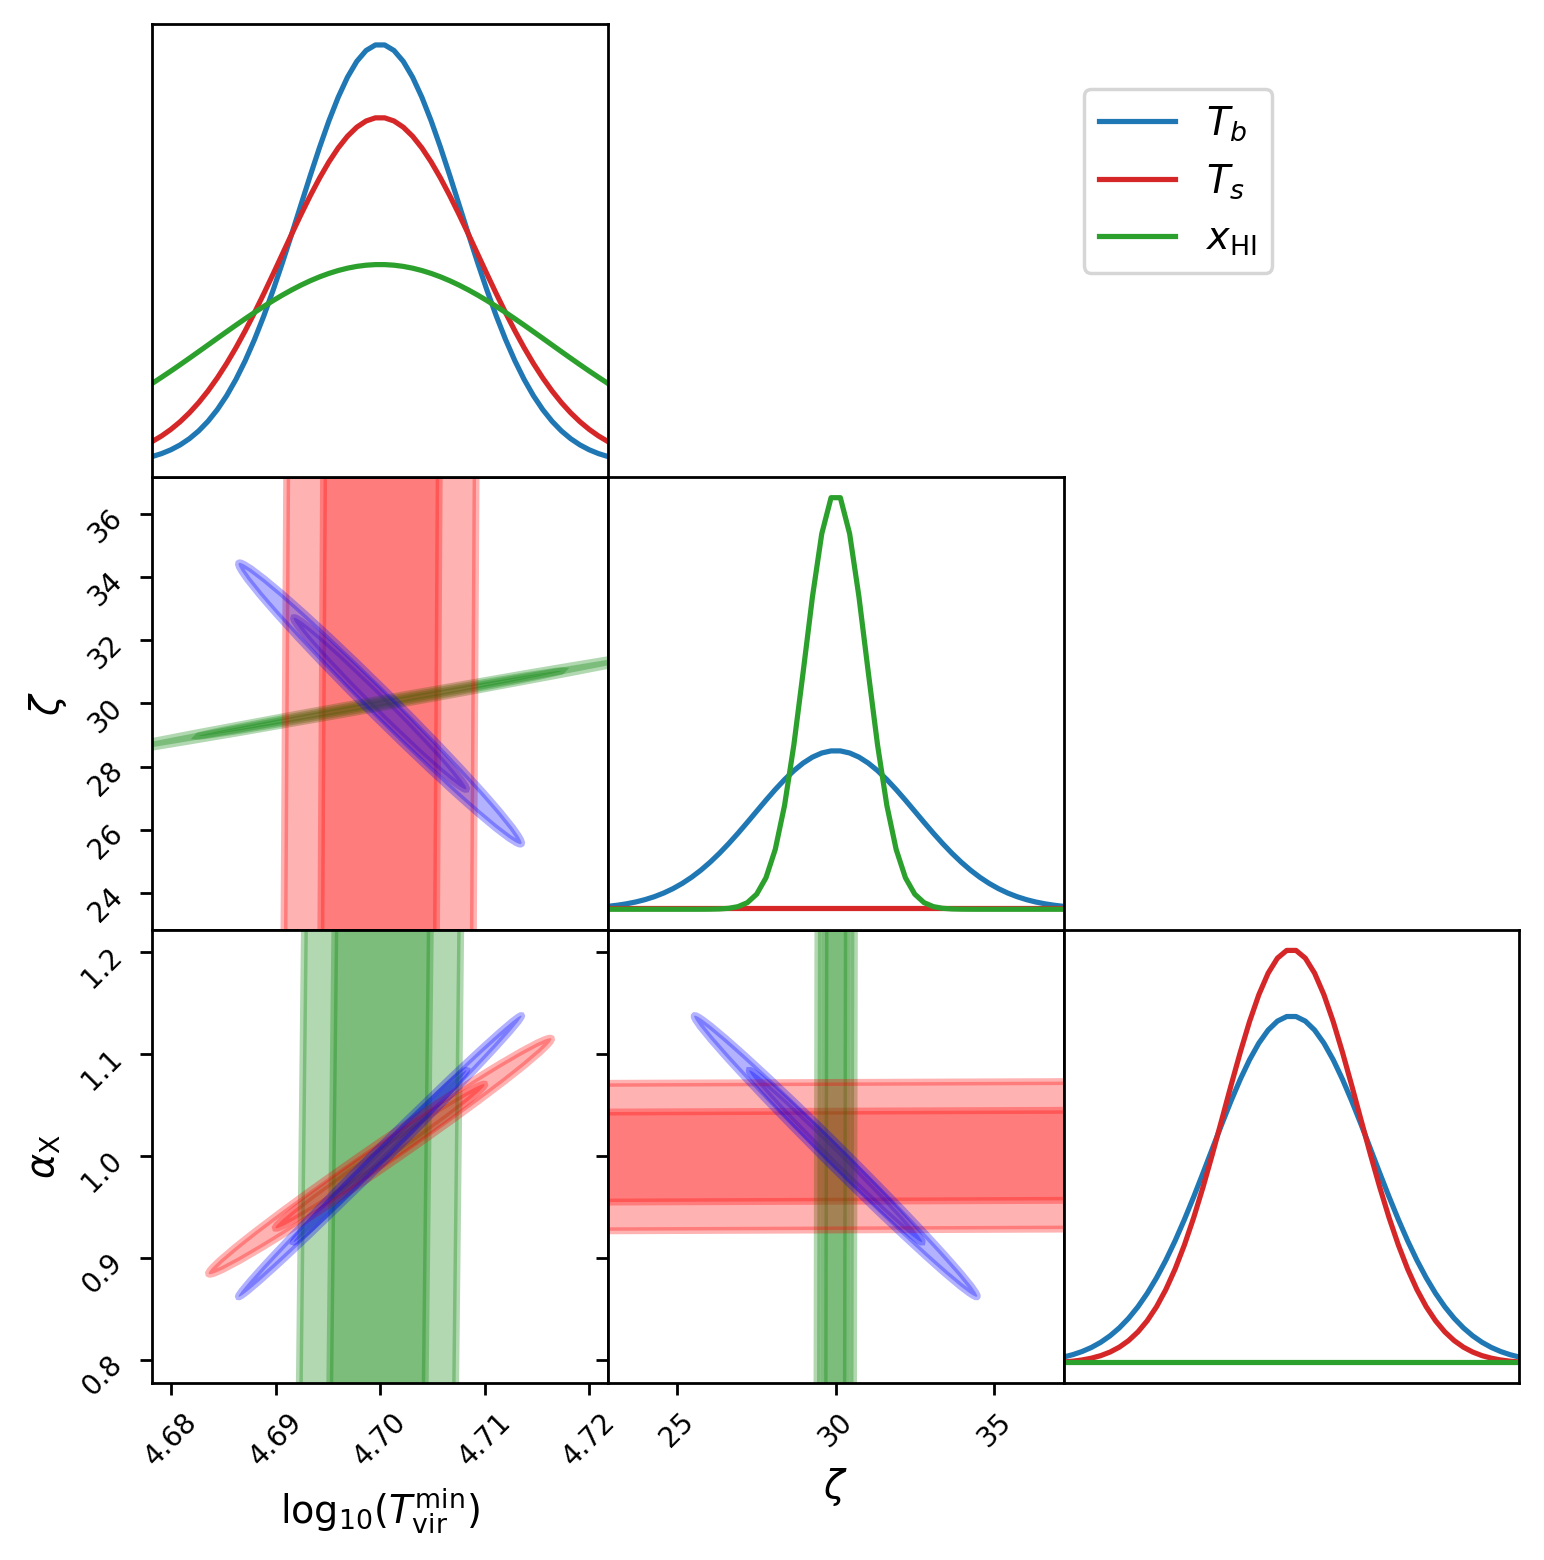

In [29]:
plot(kmin=15,kmax=88)